<a href="https://colab.research.google.com/github/renchuu/AI-ML-EDA/blob/main/abnormal_behavior_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This code was written following the paper cited below.


---

> *X. Song, "Prediction of People’s Abnormal Behaviors Based on Machine Learning Algorithms," 2022 International Conference on Machine Learning and Intelligent Systems Engineering (MLISE), Guangzhou, China, 2022, pp. 406-409, doi: 10.1109/MLISE57402.2022.00087.*



the dataset links mentioned on the paper

---


i couldnt use csdn dataset since it was paid


---


*   https://tianchi.aliyun.com/dataset/89271
*   https://www.kaggle.com/datasets/vitaminc/cigarette-smoker-detection
*   https://download.csdn.net/download/weixin_45546050/77837488
*   https://www.kaggle.com/datasets/almightyj/person-face-dataset-thispersondoesnotexist


In [ ]:
import kagglehub

# Download latest version
path_kaggle = kagglehub.dataset_download("vitaminc/cigarette-smoker-detection")

print("Path to dataset files:", path_kaggle)

Path to dataset files: /root/.cache/kagglehub/datasets/vitaminc/cigarette-smoker-detection/versions/1


In [ ]:
path_face = kagglehub.dataset_download("almightyj/person-face-dataset-thispersondoesnotexist")

print("Path to dataset files:", path_face)

100%|██████████| 4.45G/4.45G [00:56<00:00, 83.9MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/almightyj/person-face-dataset-thispersondoesnotexist/versions/1


In [ ]:
path_face = path_face + "/thispersondoesnotexist"
path_kaggle = path_kaggle + "/data"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

calling_path_tianchi = "/content/drive/MyDrive/Neural Network/train"
print("Path to dataset files:", calling_path_tianchi)

Mounted at /content/drive
Path to dataset files: /content/drive/MyDrive/Neural Network/train


In [ ]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, mean_squared_error, accuracy_score, precision_score, recall_score, f1_score
from sklearn.decomposition import PCA
import cv2
import dlib
import matplotlib.pyplot as plt
from glob import glob

class BehaviorDetector:
    def __init__(self):
        self.face_detector = dlib.get_frontal_face_detector()
        self.target_size = (64, 64)
        self.samples_per_class = 500   #in paper it was mentioned to be 500

    def preprocess_image(self, image_path):
        img = cv2.imread(image_path)
        if img is None:
            return None

        #detect faces using dlib as in paper
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        faces = self.face_detector(gray)

        if len(faces) > 0:
            face = faces[0]
            x, y, w, h = face.left(), face.top(), face.width(), face.height()
            face_img = gray[y:y+h, x:x+w]
        else:
            face_img = gray

        #detect faces using dlib as in paper
        if face_img.shape[0] > 0 and face_img.shape[1] > 0:
            try:
                resized = cv2.resize(face_img, self.target_size)
            except Exception as e:
                print(f"Error resizing image {image_path}: {e}")
                return None
        else:
            print(f"Invalid face dimensions in {image_path}")
            return None

        #normalize by dividing by 255
        normalized = resized / 255.0

        return normalized.flatten()

    def load_dataset(self, data_dir):
        X = []
        y = []

        #loading the smoking images from Kaggle
        smoking_paths = glob(f"{data_dir}/smoking/*")
        np.random.shuffle(smoking_paths)
        smoking_paths = smoking_paths[:self.samples_per_class]

        #loading the calling images from TIANCHI
        not_smoking_paths = glob(f"{data_dir}/not_smoking/*")
        np.random.shuffle(not_smoking_paths)
        not_smoking_paths = not_smoking_paths[:self.samples_per_class]

        #smoking -> label 0
        for path in smoking_paths:
            features = self.preprocess_image(path)
            if features is not None:
                X.append(features)
                y.append(1)

        #not smoking -> label 1
        for path in not_smoking_paths:
            features = self.preprocess_image(path)
            if features is not None:
                X.append(features)
                y.append(0)

        return np.array(X), np.array(y)

    def train_evaluate_models(self, X_train, X_test, y_train, y_test):
        #all defaults here are written as mentioned in paper
        models = {
            'KSVM': SVC(kernel='rbf', gamma='scale'), #default gamma
            'LSVM': SVC(kernel='linear', C=1.0), #default gamma
            'Decision Tree': DecisionTreeClassifier(),
            'Random Forest': RandomForestClassifier(n_estimators=100), #default gamma
            'KNN': KNeighborsClassifier(),
            'K-Means': KMeans(n_clusters=2)  #this is changed to 2 clusters for binary classification
        }

        results = {}

        for name, model in models.items():
            if name == 'K-Means':
          #since K-Means is unsupervised i had to handle it separately
                model.fit(X_train)
                y_pred = model.predict(X_test)
            else:
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)

            #calculating metrics as shown in paper's Table VII
            results[name] = {
                'accuracy': accuracy_score(y_test, y_pred),
                'mse': mean_squared_error(y_test, y_pred),
                'precision': precision_score(y_test, y_pred, average='weighted'),
                'recall': recall_score(y_test, y_pred, average='weighted'),
                'f1': f1_score(y_test, y_pred, average='weighted'),
                'confusion_matrix': confusion_matrix(y_test, y_pred),
                'y_pred': y_pred
            }

        return results

    #visualizing the results using PCA like Figure 8 and 9
    def visualize_pca(self, X_test, y_test, y_pred, title='Random Forest Results'):
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(X_test)

        plt.figure(figsize=(12, 5))

        #Figure 8 visualizes original data
        plt.subplot(121)
        scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_test)
        plt.title('Visualization of test_x and test_y')
        plt.legend(handles=scatter.legend_elements()[0],
                  labels=['Not Smoking', 'Smoking'])

        #Figure 9 visualizes predicted data
        plt.subplot(122)
        scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred)
        plt.title(f'Visualization of test_x and predicted_y by {title}')
        plt.legend(handles=scatter.legend_elements()[0],
                  labels=['Not Smoking', 'Smoking'])

        plt.tight_layout()
        plt.show()


if __name__ == "__main__":
    detector = BehaviorDetector()

    data_dir = path_kaggle
    X, y = detector.load_dataset(data_dir)
    if len(np.unique(y)) < 2:
        raise ValueError("Need samples from both smoking and not_smoking classes!")

    #in paper split was %80 to %20
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    results = detector.train_evaluate_models(X_train, X_test, y_train, y_test)

    #print resultd comparing like Table VII
    print("\nRESULTS OF DIFFERENT ALGORITHMS")
    print("-" * 60)
    print(f"{'Algorithm':<15} {'Accuracy':>10} {'MSE':>10} {'Precision':>10} {'Recall':>10} {'F1-score':>10}")
    print("-" * 60)

    for model_name, metrics in results.items():
        print(f"{model_name:<15} {metrics['accuracy']:10.4f} {metrics['mse']:10.4f} "
              f"{metrics['precision']:10.4f} {metrics['recall']:10.4f} {metrics['f1']:10.4f}")

        #confusion matrix in format matching paper's Tables I-VI
        print(f"\nCONFUSION MATRIX OF {model_name}")
        print("Predict")
        print("Actual         Not Smoking  Smoking")
        cm = metrics['confusion_matrix']
        print(f"Not Smoking    {cm[0][0]:11d} {cm[0][1]:8d}")
        print(f"Smoking        {cm[1][0]:11d} {cm[1][1]:8d}")
        print()

    #visualizing Random Forest results because it was the best performed in the paper
    rf_pred = results['Random Forest']['y_pred']
    detector.visualize_pca(X_test, y_test, rf_pred)

Invalid face dimensions in /content/drive/MyDrive/Neural Network/train/smoking_images/95.jpg
Invalid face dimensions in /content/drive/MyDrive/Neural Network/train/calling_images/597.jpg

RESULTS OF DIFFERENT ALGORITHMS
------------------------------------------------------------
Algorithm         Accuracy        MSE  Precision     Recall   F1-score
------------------------------------------------------------
KSVM                0.6833     0.4767     0.6794     0.6833     0.6807

CONFUSION MATRIX OF KSVM
Predict
Actual         Smoking    Calling    Normal
Smoking              52         38         10
Calling              33         54          4
Normal                6          4         99

LSVM                0.5700     0.8600     0.5588     0.5700     0.5559

CONFUSION MATRIX OF LSVM
Predict
Actual         Smoking    Calling    Normal
Smoking              47         25         28
Calling              36         34         21
Normal               15          4         90

Decision Tr

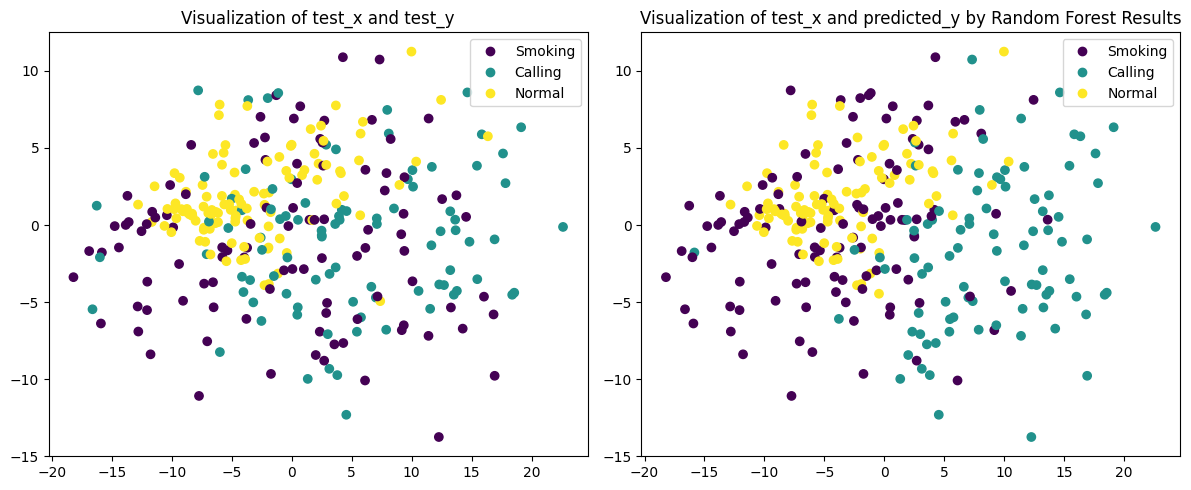

In [ ]:
class BehaviorDetector:
    def __init__(self):
        self.face_detector = dlib.get_frontal_face_detector()
        self.target_size = (64, 64)
        self.samples_per_class = 500   #in paper it was mentioned to be 500

    def preprocess_image(self, image_path):
        img = cv2.imread(image_path)
        if img is None:
            return None

        #detect faces using dlib as in paper
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        faces = self.face_detector(gray)

        if len(faces) > 0:
            face = faces[0]
            x, y, w, h = face.left(), face.top(), face.width(), face.height()
            face_img = gray[y:y+h, x:x+w]
        else:
            face_img = gray

        if face_img.shape[0] > 0 and face_img.shape[1] > 0:
            try:
                resized = cv2.resize(face_img, self.target_size)
            except Exception as e:
                print(f"Error resizing image {image_path}: {e}")
                return None
        else:
            print(f"Invalid face dimensions in {image_path}")
            return None

        normalized = resized / 255.0
        return normalized.flatten()

    def load_dataset(self, data_dir):
        X = []
        y = []

        #loading the images smoking -> 0, calling -> 1, normal -> 2
        smoking_paths = glob(f"{data_dir}/smoking_images/*")
        np.random.shuffle(smoking_paths)
        smoking_paths = smoking_paths[:self.samples_per_class]

        calling_paths = glob(f"{data_dir}/calling_images/*")
        np.random.shuffle(calling_paths)
        calling_paths = calling_paths[:self.samples_per_class]

        normal_paths = glob(f"{data_dir}/normal_images/*")
        np.random.shuffle(normal_paths)
        normal_paths = normal_paths[:self.samples_per_class]

        for path in smoking_paths:
            features = self.preprocess_image(path)
            if features is not None:
                X.append(features)
                y.append(0)  #smoking class

        for path in calling_paths:
            features = self.preprocess_image(path)
            if features is not None:
                X.append(features)
                y.append(1)  #calling class

        for path in normal_paths:
            features = self.preprocess_image(path)
            if features is not None:
                X.append(features)
                y.append(2)  #normal class

        return np.array(X), np.array(y)

    def train_evaluate_models(self, X_train, X_test, y_train, y_test):
      #all defaults here are written as mentioned in paper
        models = {
            'KSVM': SVC(kernel='rbf', gamma='scale'),  #default gamma
            'LSVM': SVC(kernel='linear', C=1.0),  #default C
            'Decision Tree': DecisionTreeClassifier(),
            'Random Forest': RandomForestClassifier(n_estimators=250),  #estimator -> 250
            'KNN': KNeighborsClassifier(),
            'K-Means': KMeans(n_clusters=3)  #since we are using three classes
        }

        results = {}

        for name, model in models.items():
          #since K-Means is unsupervised i had to handle it separately
            if name == 'K-Means':
                model.fit(X_train)
                y_pred = model.predict(X_test)
            else:
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)

            #calculating metrics as shown in paper's Table VII
            results[name] = {
                'accuracy': accuracy_score(y_test, y_pred),
                'mse': mean_squared_error(y_test, y_pred),
                'precision': precision_score(y_test, y_pred, average='weighted'),
                'recall': recall_score(y_test, y_pred, average='weighted'),
                'f1': f1_score(y_test, y_pred, average='weighted'),
                'confusion_matrix': confusion_matrix(y_test, y_pred),
                'y_pred': y_pred
            }

        return results

    #visualizing the results using PCA like Figure 8 and 9
    def visualize_pca(self, X_test, y_test, y_pred, title='Random Forest Results'):
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(X_test)

        plt.figure(figsize=(12, 5))

        plt.subplot(121)
        scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_test)
        plt.title('Visualization of test_x and test_y')
        plt.legend(handles=scatter.legend_elements()[0],
                  labels=['Smoking', 'Calling', 'Normal'])

        plt.subplot(122)
        scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred)
        plt.title(f'Visualization of test_x and predicted_y by {title}')
        plt.legend(handles=scatter.legend_elements()[0],
                  labels=['Smoking', 'Calling', 'Normal'])

        plt.tight_layout()
        plt.show()


detector = BehaviorDetector()

data_dir = calling_path_tianchi
X, y = detector.load_dataset(data_dir)

if len(np.unique(y)) < 3:
    raise ValueError("Need samples from all three classes: smoking, calling, and normal!")

#in paper split was %80 to %20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
results = detector.train_evaluate_models(X_train, X_test, y_train, y_test)

#print resultd comparing like Table VII
print("\nRESULTS OF DIFFERENT ALGORITHMS")
print("-" * 60)
print(f"{'Algorithm':<15} {'Accuracy':>10} {'MSE':>10} {'Precision':>10} {'Recall':>10} {'F1-score':>10}")
print("-" * 60)

for model_name, metrics in results.items():
    print(f"{model_name:<15} {metrics['accuracy']:10.4f} {metrics['mse']:10.4f} "
          f"{metrics['precision']:10.4f} {metrics['recall']:10.4f} {metrics['f1']:10.4f}")

    #confusion matrix in format matching paper's Tables I-VI
    print(f"\nCONFUSION MATRIX OF {model_name}")
    print("Predict")
    print("Actual         Smoking    Calling    Normal")
    cm = metrics['confusion_matrix']
    print(f"Smoking        {cm[0][0]:8d} {cm[0][1]:10d} {cm[0][2]:10d}")
    print(f"Calling        {cm[1][0]:8d} {cm[1][1]:10d} {cm[1][2]:10d}")
    print(f"Normal         {cm[2][0]:8d} {cm[2][1]:10d} {cm[2][2]:10d}")
    print()

#visualizing Random Forest results
rf_pred = results['Random Forest']['y_pred']
detector.visualize_pca(X_test, y_test, rf_pred)